In [20]:
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from poke.thinfilms import compute_thin_films_broadcasted
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [21]:
pth = 'coatings/opticoat_alsio2_12deg.csv'
data = np.genfromtxt(pth,delimiter=',').T

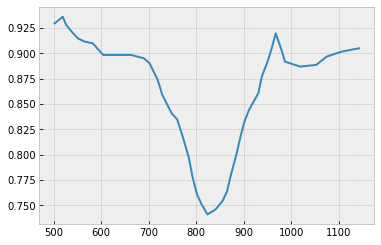

In [22]:
plt.plot(data[0],data[1])

In [23]:
spline = interp1d(data[0],data[1],kind='cubic')

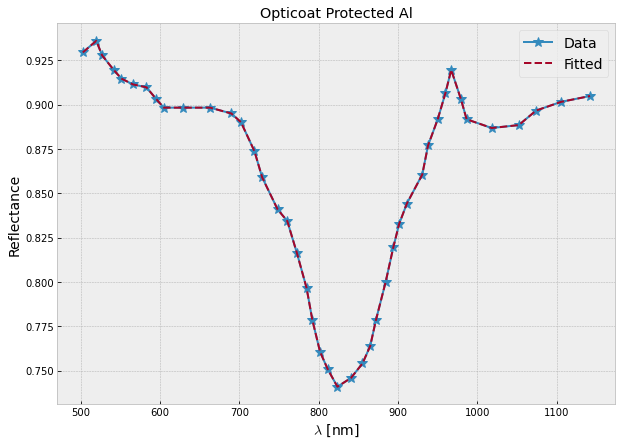

In [153]:
plt.figure(figsize=[10,7])
plt.title('Opticoat Protected Al')
plt.ylabel('Reflectance',fontsize=14)
plt.xlabel(r'$\lambda$'+' [nm]',fontsize=14)
plt.plot(data[0],data[1],label='Data',marker='*',markersize=10)
plt.plot(data[0],spline(data[0]),label='Fitted',linestyle='dashed')
plt.legend(fontsize=14)
plt.show()

## Now we load the constituent materials

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


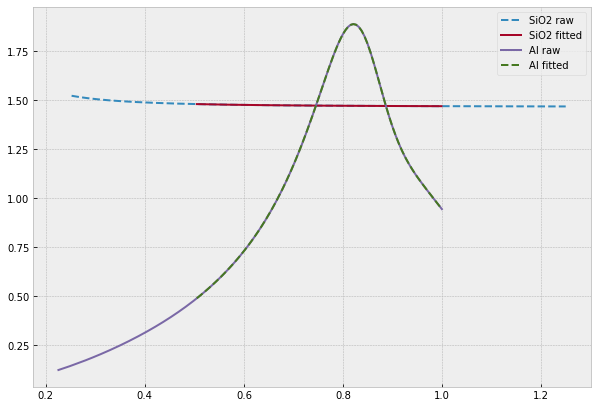

In [42]:
aoi = 12
wvl = np.arange(505,1000,1)

# create coating splines
pth_SiO2 = 'coatings/Gao_SiO2.csv'
dat_SiO2 = np.genfromtxt(pth_SiO2,delimiter=',',skip_header=1)[:500].T
n_SiO2 = interp1d(dat_SiO2[0],dat_SiO2[1])

pth_Al = 'coatings/Cheng_Al.csv'
ndat_Al = np.genfromtxt(pth_Al,delimiter=',',skip_header=1)[:427].T
kdat_Al = np.genfromtxt(pth_Al,delimiter=',',skip_header=1)[429:].T
nd_Al = interp1d(ndat_Al[0],ndat_Al[1])
k_Al = interp1d(kdat_Al[0],kdat_Al[1])
n_Al = lambda wave: nd_Al(wave) + 1j*k_Al(wave)

plt.figure(figsize=[10,7])
plt.plot(dat_SiO2[0],dat_SiO2[1],label='SiO2 raw',linestyle='dashed')
plt.plot(wvl*1e-3,n_SiO2(wvl*1e-3),label='SiO2 fitted')
plt.plot(ndat_Al[0],ndat_Al[1],label='Al raw')
plt.plot(wvl*1e-3,n_Al(wvl*1e-3),label='Al fitted',linestyle='dashed')
plt.legend()
plt.show()


## Optimize a spline using SiO2 layer thickness as variable to get final solution

In [53]:
def fit_coating(d):

    # build stack
    stack = [
        (n_SiO2(wvl*1e-3),d),
        (n_Al(wvl*1e-3))
    ]

    rs,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Al(wvl*1e-3))
    rp,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Al(wvl*1e-3),polarization='p')
    avg = (np.abs(rs)**2 + np.abs(rp)**2)/2

    cost = np.sum((spline(wvl)-avg)**2)/avg.size

    return cost

In [190]:
# fit_coating(10)
results = minimize(fit_coating,200,method='L-BFGS-B',options={'maxiter':1000})

In [191]:
results.x

array([160.25043448])

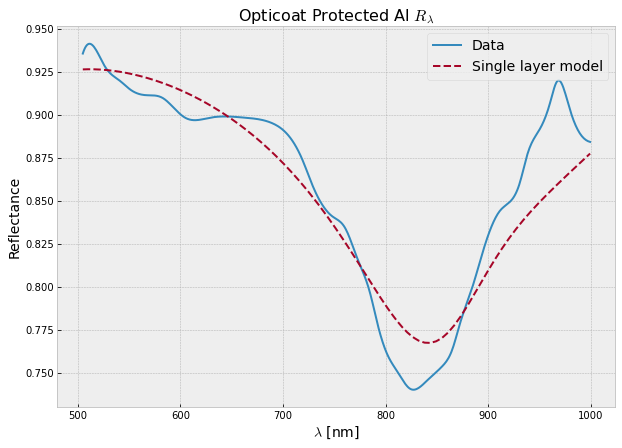

In [192]:
# build stack
stack = [
    (n_SiO2(wvl*1e-3),results.x),
    (n_Al(wvl*1e-3))
]

rs,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Al(wvl*1e-3))
rp,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Al(wvl*1e-3),polarization='p')
avg = (np.abs(rs)**2 + np.abs(rp)**2)/2

plt.figure(figsize=[10,7])
plt.title('Opticoat Protected Al'+r' $R_{\lambda}$',fontsize=16)
plt.plot(wvl,spline(wvl),label='Data')
plt.plot(wvl,avg,label='Single layer model',linestyle='dashed')
plt.legend(fontsize=14)
plt.ylabel('Reflectance',fontsize=14)
plt.xlabel(r'$\lambda$'+' [nm]',fontsize=14)
plt.show()

In [193]:
np.std(spline(wvl)-avg)

0.01996935162011213